In [67]:
# Web scraping libraries.
import requests
from bs4 import BeautifulSoup

#Sentiment Analisys libraries.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import mtranslate

# Plots libraries.
import matplotlib.pyplot as plt
from collections import Counter

# System libraries.
import sys
import json
import os
import urllib
import datetime

# Lithops.
from threading import Thread
from lithops.multiprocessing import Pool
from lithops import Storage

# Http header.
header = { 'user-agent':'Mozilla/5.0 (X11; Linux x86_64; rv:78.0) Gecko/20100101 Firefox/78.0' }

SEARCH_KEY = ''
BUCKET = 'news-bucket'

# The higher, more results. The lower, less results.
DEFAULT_SEARCH_RESULTS = 200

In [68]:
###############################################
# WEB SCRAWLER FOR THE WEBSITE WWW.CCMA.CAT   #
###############################################
def ccma_process_news(link):
    
    analyzer = SentimentIntensityAnalyzer()
    news_format = {}
    try:
        r = requests.get(link, headers=header)
    except requests.exceptions.TooManyRedirects:
        return 0

    soup = BeautifulSoup(r.text, 'html.parser')
    frame = soup.find("div", class_='span8')
    
    # Put news link.
    news_format['link'] = link

    # Get news header.
    news_format['title'] = frame.find("h1", class_='titol').text

    # Get news starter.
    starter = frame.find("h2", class_='entradeta')
    if starter is not None:
        starter = starter.text
    else: starter = ''
    news_format['starter'] = starter.replace("\n","").replace("\t","")

    # Get news date.
    news_format['date'] = frame.find("time", class_='data').text.split(" ")[0]

    # Get news paragraphs.
    frame = frame.find("div", class_='R-itemNotiCos')
    body = ''
    for parraph in frame.find_all("p"):
        body = body+" "+parraph.text
    news_format['body'] = body.replace("\n","").replace("\t","")

    #Get news sentiment analysis.
    try:
        news_format['sentiment'] = analyzer.polarity_scores(mtranslate.translate(news_format['starter']+'\n'+news_format['body'],'en','auto'))['compound']
    except urllib.error.HTTPError:
        return 0
        
    # Get news total words number.
    word_counter = 0
    for field in news_format.values():
        word_counter += len(str(field).split(" "))
    news_format['words_number'] = word_counter

    # Store the news content to the cloud COS.
    storage = Storage()
    storage.put_object(bucket='news-bucket', key=SEARCH_KEY+'/ccma/'+news_format['title'].replace(" ","_")+'.json', body = json.dumps(news_format))

    return 1

def ccma_get_links():

    # Auxiliar variables.
    link_to_news = []

    # We create HTML parser.
    r = requests.get('https://www.ccma.cat/cercador/?text='+SEARCH_KEY+'&profile=noticies&pagina=1', headers=header)
    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the number of pages in the website.
    pages = soup.find(class_='numeracio')
    if pages is None:
        pages = 0
    else:
        pages = pages.text.split(" ")[3]

    # Get the links to the news.
    for i in range(int(pages)+1):
        r = requests.get('https://www.ccma.cat/cercador/?text='+SEARCH_KEY+'&profile=noticies&pagina='+str(i), headers=header)
        soup = BeautifulSoup(r.text, 'html.parser')

        for news in soup.find_all("li", class_='F-llistat-item'):
            # We get the link to the news page.
            link_to_news.append("https://www.ccma.cat"+news.find("a").get('href'))
    
    return link_to_news

def ccma_query():

    link_to_news = ccma_get_links()

    # Start cloud multiprocessing.
    with Pool() as pool:
        result = pool.map(ccma_process_news, link_to_news)
    
    count = sum(result)

    if count == 0:
        return "ccma: no results found."
    else:
        return "ccma: "+str(count)+" results found."

# -------------------------------------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------------------------------

In [69]:
###########################################################
# WEB SCRAWLER FOR THE WEBSITE WWW.DIARIDETARRAGONA.COM   #
###########################################################

def dtg_process_news(link):
     
    analyzer = SentimentIntensityAnalyzer()
    news_format = {}
    try:
        r = requests.get(link, headers=header)
    except requests.exceptions.TooManyRedirects:
        return 0

    soup = BeautifulSoup(r.text, 'html.parser')
    head = soup.find("header", class_='news-header')

    # Put news link.
    news_format['link'] = link

    # Get news header.
    news_format['title'] = head.find("h1", class_='news-title').text.replace("\n","").replace("\t","")

    # Get news starter.
    starter = head.find("div",class_='news-excerpt')
    if starter is not None:
        starter = starter.text
    else: starter = ''
    news_format['starter'] = starter.replace("\n","").replace("\t","")

    # Get news date.
    news_format['date'] = head.find("time", class_='news-date').text.replace("\n","").replace("\t","").split(" ")[0]

    # Get news paragraphs.
    frame = soup.find("div", class_='news-body')
    body = ''
    for parraph in frame.find_all("p"):
        body = body+" "+parraph.text
    news_format['body'] = body.replace("\n","").replace("\t","")

    #Get news sentiment analysis.
    try:
        news_format['sentiment'] = analyzer.polarity_scores(mtranslate.translate(news_format['starter']+'\n'+news_format['body'],'en','auto'))['compound']
    except urllib.error.HTTPError:
        return 0
    
    # Get news total words number.
    word_counter = 0
    for field in news_format.values():
        word_counter += len(str(field).split(" "))
    news_format['words_number'] = word_counter

    # Store the news content to the cloud COS.
    storage = Storage()
    storage.put_object(bucket='news-bucket', key=SEARCH_KEY+'/diaridetarragona/'+news_format['title'].replace(" ","_")+'.json', body = json.dumps(news_format))

    return 1

def dtg_get_links():

    # Auxiliar variables.
    link_to_news = []

    # We create HTML parser.
    r = requests.get('https://www.diaridetarragona.com/ajax/get_search_news.html?viewmore=%2Fajax%2Fget_search_news.html&page=1&size='+str(DEFAULT_SEARCH_RESULTS)+'&search='+SEARCH_KEY, headers=header)
    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the links to the news.
    for news in soup.find_all("div", class_='news-data'):
        # We get the link to the news page.
        link_to_news.append("https://www.diaridetarragona.com"+news.find("a").get('href'))

    return link_to_news

def dtg_query():
    
    link_to_news = dtg_get_links()

    # Start cloud multiprocessing.
    with Pool() as pool:
        result = pool.map(dtg_process_news, link_to_news)
    count = sum(result)
    
    if count == 0:
        return "DiarideTarragona: no results found."
    else:
        return "DiarideTarragona: "+str(count)+" results found."


In [70]:
###########################################################
# WEB SCRAWLER FOR THE WEBSITE WWW.DIARIDEBARCELONA.CAT   #
###########################################################

def dbc_process_news(link):

    analyzer = SentimentIntensityAnalyzer()
    news_format = {}
    try:
        r = requests.get(link, headers=header)
    except requests.exceptions.TooManyRedirects:
        return 0
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # Put news link.
    news_format['link'] = link

    # Get news header.
    title = soup.find("div", class_='title-opening-section')
    if title is None:
        return 0         #  Case we are threatting an opinion...
    news_format['title'] = title.text.replace("\n","").replace("\t","").replace("\"","")

    # Get news starter.
    description = soup.find("div", class_='description')
    if description is None:
        return 0         # Case we are threatting an interview...
    news_format['starter'] = description.text.replace("\n","").replace("\t","").replace("\xa0"," ").replace("\"","")

    # Get news date.
    frame = soup.find("div", class_='info-date')
    date = frame.find("span", class_='date').text
    news_format['date'] = date.replace(" ","").replace("d’","/").replace("de","/").replace("gener","01/").replace("febrer","02/").replace("març","03/").replace("abril","04/").replace("maig","05/").replace("juny","06/").replace("juliol","07/").replace("agost","08/").replace("setembre","09/").replace("octubre","10/").replace("novembre","11/").replace("desembre","12/")
    # Get news paragraphs.
    frame = soup.findAll("div", class_='component-html pb-3')[3]
    body = ''
    for parraph in frame.find_all("p"):
        body = body+" "+parraph.text
    news_format['body'] = body.replace("\n","").replace("\t","").replace("\xa0"," ").replace("\"","")
    
    #Get news sentiment analysis.
    try:
        news_format['sentiment'] = analyzer.polarity_scores(mtranslate.translate(news_format['starter']+'\n'+news_format['body'],'en','auto'))['compound']
    except urllib.error.HTTPError:
        return 0

    # Get news total words number.
    word_counter = 0
    for field in news_format.values():
        word_counter += len(str(field).split(" "))
    news_format['words_number'] = word_counter

    # Store the news content to the cloud COS.
    storage = Storage()
    storage.put_object(bucket='news-bucket', key=SEARCH_KEY+'/diaridebarcelona/'+news_format['title'].replace(" ","_")+'.json', body = json.dumps(news_format))

    return 1

def dbc_get_links():

    # Auxiliar variables.
    link_to_news = []

    # We create HTML parser.
    r = requests.get('https://www.diaridebarcelona.cat/search?q='+sys.argv[1], headers=header)
    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the number of pages in the website.
    frame = soup.find(lambda tag: tag.name == 'li' and tag.get('class') == ['first'])
    if frame is not None:
        pages = frame.find("a").get('href')
        pages = pages.split("=")[-1]
    else:
        pages = 0  

    # Get the links to the news.
    for i in range(int(pages)+1):
        r = requests.get('https://www.diaridebarcelona.cat/search?q='+SEARCH_KEY+'&start='+str(i), headers=header)
        soup = BeautifulSoup(r.text, 'html.parser')

        for news in soup.find_all(class_='col-sm-6 col-lg-3 mb-20px mb-lg-30px'):
            # We get the link to the news page.
            news = news.find(class_='h1 modul-petit')
            link_to_news.append(news.find("a").get('href'))
    
    return link_to_news

def dbc_query():
    link_to_news = dbc_get_links()

    # Start cloud multiprocessing.
    with Pool() as pool:
        result = pool.map(dbc_process_news, link_to_news)
    count = sum(result)

    if count == 0:
        print("DiarideBarcelona: no results found.")
    else:
        print("DiarideBarcelona: "+str(count)+" results found.")

In [71]:
###########################################
#         MAIN AUXILIAR FUNCTIONS         #
###########################################

def menu():
    print("0 - Leave the search engine.")
    print("1 - Regular search using a topic.")
    print("2 - Advanced search using filters.")
    print("3 - Advanced search with filters and data analytics.")
    return int(input("Choice: "))

def get_object_cloud(key):
        stor = Storage()
        return json.loads(stor.get_object(BUCKET,key))

def regularSearch():
    global SEARCH_KEY
    SEARCH_KEY = ''
    while SEARCH_KEY == '':
        SEARCH_KEY = input("Choose the topic: ")
    
    ccma_thread = Thread(target=ccma_query)
    ccma_thread.start()
    dtg_thread = Thread(target=dtg_query)
    dtg_thread.start()
    dbc_thread = Thread(target=dbc_query)
    dbc_thread.start()
    
    ccma_thread.join()
    dtg_thread.join()
    dbc_thread.join()

    storage = Storage()
    news_list = storage.list_keys(BUCKET,SEARCH_KEY+'/')
    with Pool() as pool:
        news = pool.map(get_object_cloud, news_list)
    return news
    
def advancedFilterSearch():
    apply_sentiment = input("Filter by sentiment analysis? (bias[-1,1] more/less) (blank if none)   ")
    apply_wordnumber = input("Filter by word numbers (get the news with more/less words than specified)? (bias more/less) (blank if none)   ")
    apply_date = input("Filter by date (get the news before/after the specified date)? (before/after date[yyyy/mm/dd]) (blank if none)   ")
    apply_specific_word = input("Filter by specific word (get the news contaning the word)? (word) (blank if none)   ")
    news = regularSearch()

    filtered_news = []
    for n in news:
        filtered_news.append(n)

    for n in news:

        if apply_specific_word:
            if apply_specific_word not in json.dumps(n):
                filtered_news.remove(n)
                continue

        if apply_sentiment:
            bias = apply_sentiment.split(" ")[0]
            sign = apply_sentiment.split(" ")[1]
            if sign == 'more' and float(n['sentiment']) < float(bias):
                filtered_news.remove(n)
                continue

            elif sign == 'less' and float(n['sentiment']) > float(bias):
                filtered_news.remove(n)
                continue

        if apply_wordnumber:
            bias = apply_wordnumber.split(" ")[0]
            op = apply_wordnumber.split(" ")[1]
            if op == 'more' and int(n['words_number']) < int(bias):
                filtered_news.remove(n)
                continue

            elif op == 'less' and int(n['words_number']) > int(bias):
                filtered_news.remove(n)
                continue
        
        if apply_date:
            date = apply_date.split(" ")[1].split("/")
            specified_date = datetime.datetime(int(date[0]),int(date[1]),int(date[2]))
            news_date = n['date'].split("/")
            time_frame = apply_date.split(" ")[0]
            if time_frame == 'before' and datetime.datetime(int(news_date[2]),int(news_date[1]),int(news_date[0])) > specified_date:
                filtered_news.remove(n)
                continue

            elif time_frame == 'after' and datetime.datetime(int(news_date[2]),int(news_date[1]),int(news_date[0])) < specified_date:
                filtered_news.remove(n)
                continue
    return filtered_news

def advancedAnalyticsSearch():
    news = advancedFilterSearch()

    news_wn = []
    news_sa = []
    news_date = []

    for n in news:
        news_wn.append(int(n['words_number']))
        news_sa.append(float(n['sentiment']))
        news_date.append(n['date'])

    count = Counter(news_wn)
    plt.suptitle('Words number in news')
    plt.bar(count.keys(),count.values())
    plt.show()

    count = Counter(news_sa)
    plt.suptitle('Sentiment analysis in news')
    plt.bar(count.keys(),count.values())
    plt.show()

    count = Counter(news_date)
    plt.suptitle('News dates')
    plt.bar(count.keys(),count.values())
    plt.show()
    
    return news

def printToFile(vector):
    with open("results.txt","w") as f:
        count = 0
        for news in vector:
            count += 1
            for field in news.values():
                f.write(str(field)+"\n")
            f.write("****************************************************************************\n")
    print ("Number of indexed news: "+str(count))
    
def options(choice):
    if choice == 1: printToFile(regularSearch())
    elif choice == 2: printToFile(advancedFilterSearch())
    elif choice == 3: printToFile(advancedAnalyticsSearch())
    elif choice == 0: print("Leaving...")
    else: print("Wrong option.")

0 - Leave the search engine.
1 - Regular search using a topic.
2 - Advanced search using filters.
3 - Advanced search with filters and data analytics.
2021-06-18 18:01:01,490 [INFO] lithops.config -- Lithops v2.3.4
2021-06-18 18:01:01,506 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: eu-gb
2021-06-18 18:01:01,507 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-south - Namespace: lluisoriol.colom@estudiants.urv.cat_dev
2021-06-18 18:01:01,508 [INFO] lithops.executors -- Serverless Executor created with ID: ea82e5-36
2021-06-18 18:01:01,509 [INFO] lithops.invokers -- ExecutorID ea82e5-36 | JobID M000 - Selected Runtime: repstail123/sdpractica2:sdpract2 - 512MB
2021-06-18 18:01:01,515 [INFO] lithops.job.job -- ExecutorID ea82e5-36 | JobID M000 - Uploading function and data - Total: 2.3KiB
2021-06-18 18:01:02,156 [INFO] lithops.invokers -- ExecutorID ea82e5-36 | JobID M000 - Starting function invocation: C

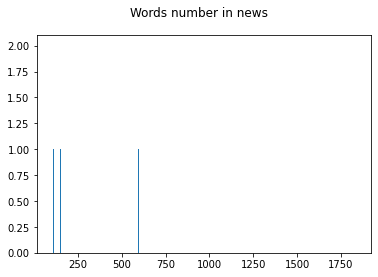

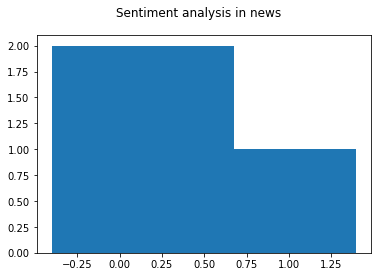

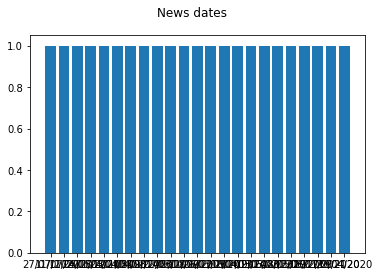

Number of indexed news: 23
0 - Leave the search engine.
1 - Regular search using a topic.
2 - Advanced search using filters.
3 - Advanced search with filters and data analytics.


ValueError: invalid literal for int() with base 10: ''

In [72]:
#########################
#         MAIN          #
#########################
if __name__ == '__main__':
    choice = -1
    while choice != 0:
        choice = menu()
        options(choice)
    print("See u soon")